In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Load the CSV files and concat them

In [2]:
file1 = 'BTC_Data_1.csv'
file2 = 'BTC_Data_2.csv'
file3 = 'BTC_Data_3.csv'
file4 = 'BTC_Data_4.csv'

In [3]:
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)
df4 = pd.read_csv(file4)

In [4]:
btc_df = pd.concat([df1, df2, df3, df4])
btc_df.head()

,time,low,high,open,close,volume
0,2016-05-31 00:00:00,532.56,532.78,532.56,532.78,7.85012
1,2016-05-31 00:01:00,532.71,532.81,532.81,532.71,0.20950
2,2016-05-31 00:02:00,532.73,532.82,532.73,532.82,1.52906
3,2016-05-31 00:03:00,532.85,532.97,532.85,532.97,4.94657
4,2016-05-31 00:04:00,532.49,533.25,532.49,533.25,5.72112


In [5]:
btc_df['time'] = pd.to_datetime(btc_df['time'])

# Plot of the entire 8 years BTC Data

<Axes: title={'center': 'Bitcoin Weighted Price'}, xlabel='time'>

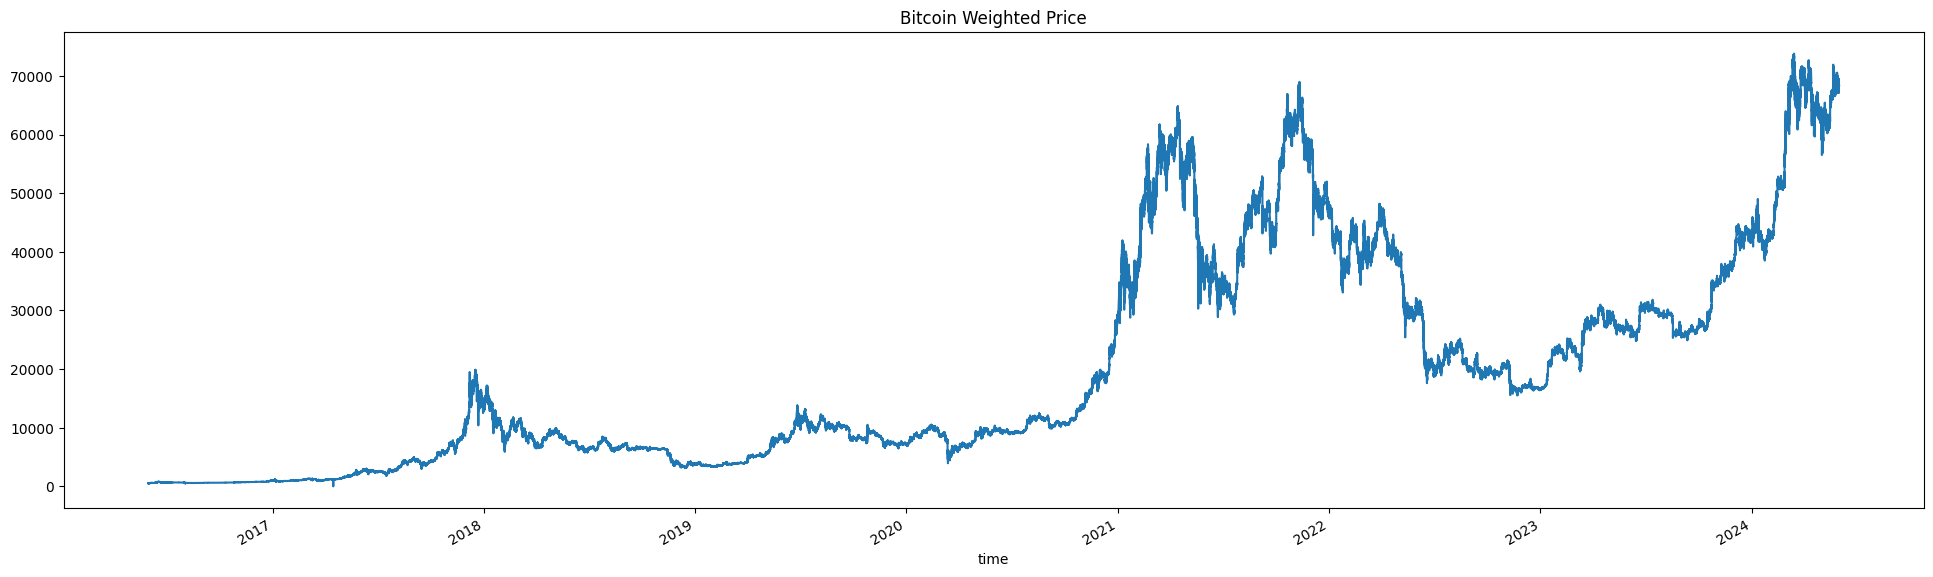

In [6]:
btc_df.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [7]:
btc_df['date'] = pd.to_datetime(btc_df['time'],unit='s').dt.date

display(btc_df.head())

group = btc_df.groupby('date')

groupby_date = group['close'].mean()

,time,low,high,open,close,volume,date
0,2016-05-31 00:00:00,532.56,532.78,532.56,532.78,7.85012,2016-05-31
1,2016-05-31 00:01:00,532.71,532.81,532.81,532.71,0.20950,2016-05-31
2,2016-05-31 00:02:00,532.73,532.82,532.73,532.82,1.52906,2016-05-31
3,2016-05-31 00:03:00,532.85,532.97,532.85,532.97,4.94657,2016-05-31
4,2016-05-31 00:04:00,532.49,533.25,532.49,533.25,5.72112,2016-05-31


In [8]:
display(groupby_date.head(10))

date
2016-05-31    533.684574
2016-06-01    533.245138
2016-06-02    536.239000
2016-06-03    555.243833
2016-06-04    576.788654
2016-06-05    578.002186
2016-06-06    583.115042
2016-06-07    583.126190
2016-06-08    579.181246
2016-06-09    579.304649
Name: close, dtype: float64

In [9]:
prediction_days = 120
df_train = groupby_date[:len(groupby_date)-prediction_days].values.reshape(-1,1)
df_test = groupby_date[len(groupby_date)-prediction_days:].values.reshape(-1,1)

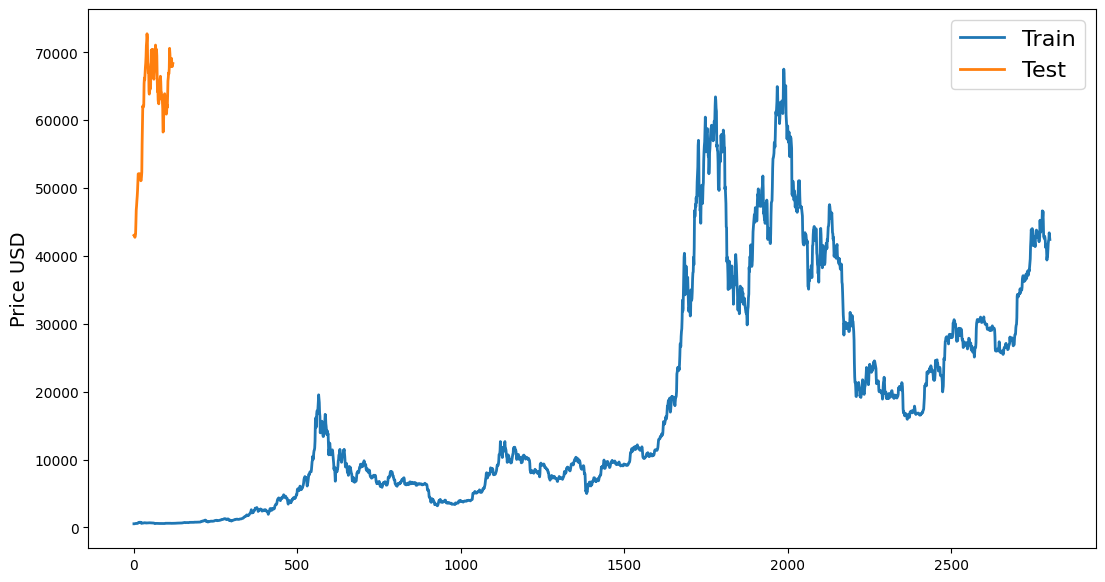

In [10]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [11]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

# Dataset Generation
Before training an LSTM model, it is necessary to prepare the time series data. For instance, a univariate time series can be represented as an observation vector:

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

A supervised learning algorithm requires data to be provided as a set of samples, where each sample consists of an input component **X** and an output component **y**. The model learns to map the input to the output based on the provided examples.

For time series data, this means converting the series into samples with input and output components. In a univariate time series problem focused on one-step forecasting, we can use observations from previous time points as input and the observation at the current time point as the output. For example, a 10-step univariate sequence can be expressed as a supervised learning problem where the input consists of 3 time steps and the output is 1 time step, as shown below:

[1, 2, 3, 4, 5], [6]

[2, 3, 4, 5, 6], [7]

[3, 4, 5, 6, 7], [8]

1,2,3,4,5 are inputs and 6 is taken as output, this as an input-output pair goes inside the network. Similarly for 2,3,4,5,6 and 7. So here we basically consider a **window of size 5**. That will shift forward by 1 unit/data point. 

We also need to define a **"lookback period"** which defines how many previous timesteps are used in order to predict the subsequent timestep. So if lookback is 5, that means we will be using timestep $t-4, t-3, t-2, t-1$ & $t$ to predict $t+1$.

In [12]:
def dataset_generator(dataset, look_back=5):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator(scaled_train)
testX, testY = dataset_generator(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (2798, 5)
trainY:  (2798,)
testX:  (115, 5)
testY (115,)


# RNN Model

In [13]:
# Define RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=128, return_sequences=True, input_shape=(trainX.shape[1], 1)))
rnn_model.add(Dropout(0.3))
rnn_model.add(SimpleRNN(units=128))
rnn_model.add(Dropout(0.3))
rnn_model.add(Dense(units=1))

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_rnn_model.keras', save_best_only=True, monitor='val_loss')

# Train RNN model
rnn_history = rnn_model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY))

Epoch 1/100


C:\Users\sayed\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0799 - val_loss: 0.0135
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0115
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 - val_loss: 0.0117
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0091
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0082
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0078
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0081
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0109
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0058
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0062
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_lo

# LSTM Model

In [14]:
# Improved LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=128, return_sequences=True, input_shape=(trainX.shape[1], 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(units=128))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_loss')

# Train improved LSTM model
lstm_history = lstm_model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0428 - val_loss: 0.0099
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0091
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0097
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0096
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0085
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 0.0090
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0088
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4559e-04 - val_loss: 0.0084
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 0.0086
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7624e-04 - val_loss: 0.0087
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6787e-04 - val_loss: 0.0086
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

# GRU Model

In [15]:
# Improved GRU model
gru_model = Sequential()
gru_model.add(GRU(units=128, return_sequences=True, input_shape=(trainX.shape[1], 1)))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(units=128))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(units=1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_gru_model.keras', save_best_only=True, monitor='val_loss')

# Train improved GRU model
gru_history = gru_model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0290 - val_loss: 0.0057
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 0.0068
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5876e-04 - val_loss: 0.0059
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9901e-04 - val_loss: 0.0056
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3315e-04 - val_loss: 0.0059
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5020e-04 - val_loss: 0.0060
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1080e-04 - val_loss: 0.0055
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s

# Evaluation

In [16]:
# Evaluate the models
rnn_loss = rnn_model.evaluate(testX, testY)
lstm_loss = lstm_model.evaluate(testX, testY)
gru_loss = gru_model.evaluate(testX, testY)

print(f'RNN Test Loss: {rnn_loss}')
print(f'LSTM Test Loss: {lstm_loss}')
print(f'GRU Test Loss: {gru_loss}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 
RNN Test Loss: 0.0029562890995293856
LSTM Test Loss: 0.0030235864687711
GRU Test Loss: 0.0024207469541579485


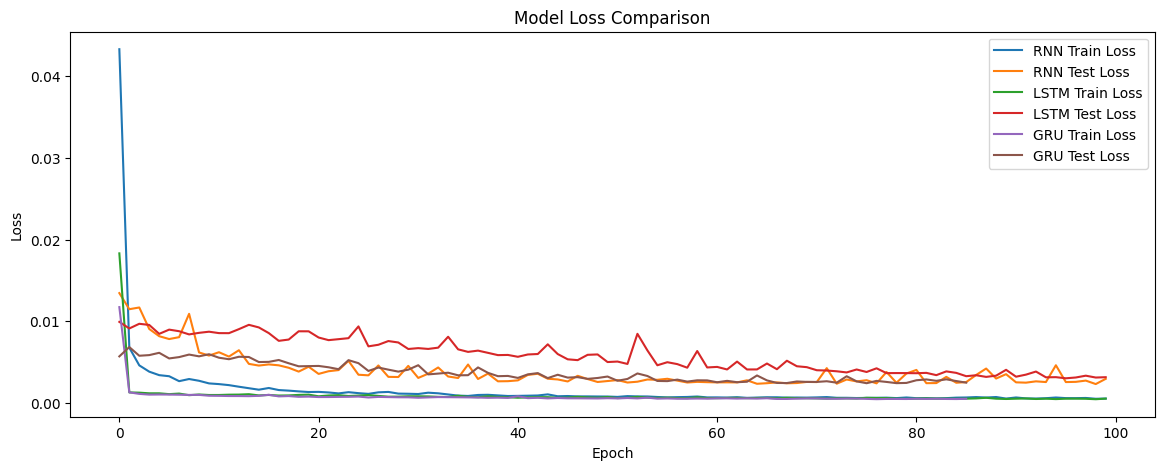

In [17]:
# Plot training & validation loss values for comparison
plt.figure(figsize=(14, 5))

# RNN
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Test Loss')

# LSTM
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Test Loss')

# GRU
plt.plot(gru_history.history['loss'], label='GRU Train Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Test Loss')

plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prediction

In [18]:
# Make predictions
rnn_predictions = rnn_model.predict(testX)
lstm_predictions = lstm_model.predict(testX)
gru_predictions = gru_model.predict(testX)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000159AA24D440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [19]:
# Inverse transform the predictions
rnn_predictions = scaler_test.inverse_transform(rnn_predictions)
lstm_predictions = scaler_test.inverse_transform(lstm_predictions)
gru_predictions = scaler_test.inverse_transform(gru_predictions)

# Inverse transform the true prices
true_prices = scaler_test.inverse_transform(testY.reshape(-1, 1))

# RNN Plot

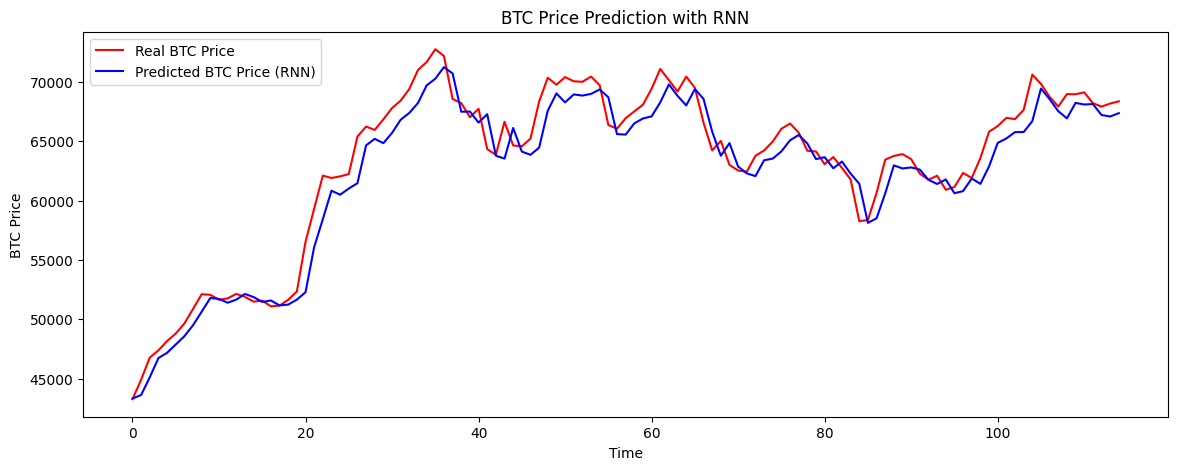

In [20]:
plt.figure(figsize=(14, 5))
plt.plot(true_prices, color='red', label='Real BTC Price')
plt.plot(rnn_predictions, color='blue', label='Predicted BTC Price (RNN)')
plt.title('BTC Price Prediction with RNN')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

# LSTM Plot

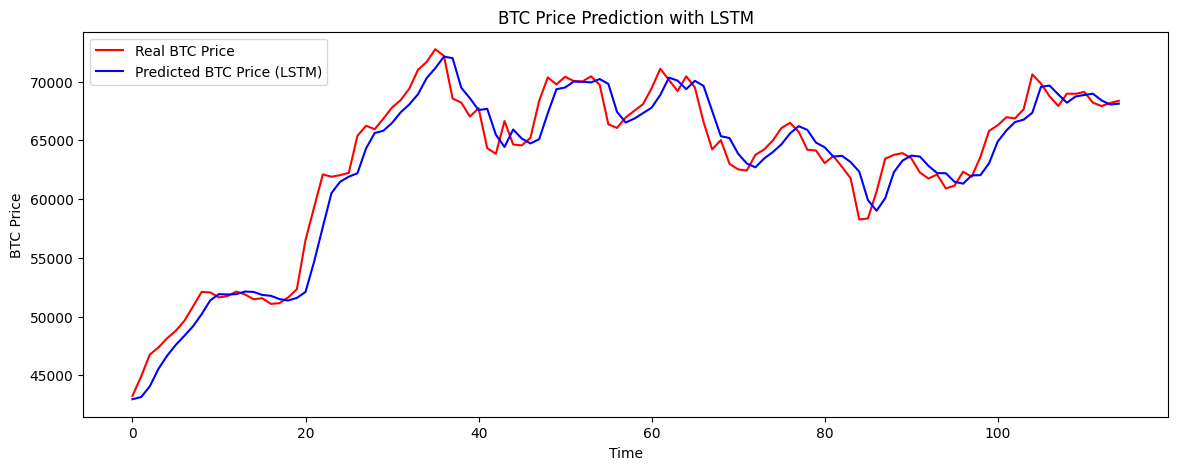

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(true_prices, color='red', label='Real BTC Price')
plt.plot(lstm_predictions, color='blue', label='Predicted BTC Price (LSTM)')
plt.title('BTC Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

# GRU Plot

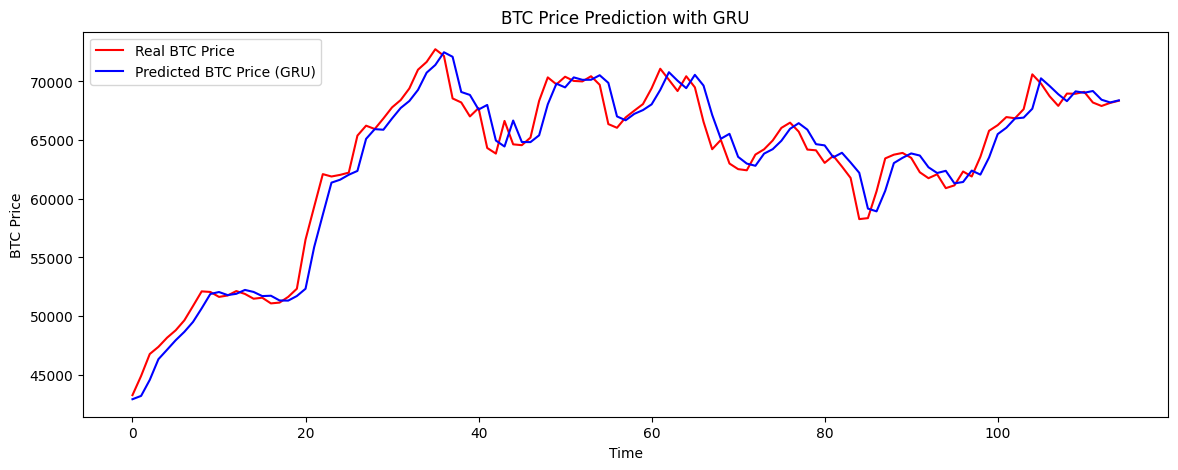

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(true_prices, color='red', label='Real BTC Price')
plt.plot(gru_predictions, color='blue', label='Predicted BTC Price (GRU)')
plt.title('BTC Price Prediction with GRU')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

# Predicting Price for Future 10 Days

In [23]:
future_data_df = pd.read_csv('future_10_days.csv')
future_dates = pd.to_datetime(future_data_df['time'])
future_values = future_data_df['close'].values.reshape(-1, 1)

# Scale the future data
scaled_future = scaler_test.transform(future_values)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
def predict_with_model(model, data, look_back=5):
    dataX = []
    dataY = []
    
    for i in range(len(data) - look_back):
        window_size_x = data[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(data[i + look_back, 0])
    
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
    with torch.no_grad():
        inputs = torch.Tensor(dataX).unsqueeze(2).to(device)
        predictions = model(inputs).cpu().numpy()
    
    return predictions, dataY

In [26]:
# Ensure your look_back value matches what you used during training
look_back = 5

# Predict with each model
rnn_predictions, rnn_targets = predict_with_model(rnn_model, scaled_future, look_back)
lstm_predictions, lstm_targets = predict_with_model(lstm_model, scaled_future, look_back)
gru_predictions, gru_targets = predict_with_model(gru_model, scaled_future, look_back)

# Inverse transform the predictions
rnn_predictions = scaler_test.inverse_transform(rnn_predictions)
lstm_predictions = scaler_test.inverse_transform(lstm_predictions)
gru_predictions = scaler_test.inverse_transform(gru_predictions)

Instructions for updating:
Use tf.identity with explicit device placement instead.


In [27]:
def RMSE(y, y_hat):
    rmse = mean_squared_error(y, y_hat, squared=False)
    print("Root Mean Squared Error (RMSE):", rmse)

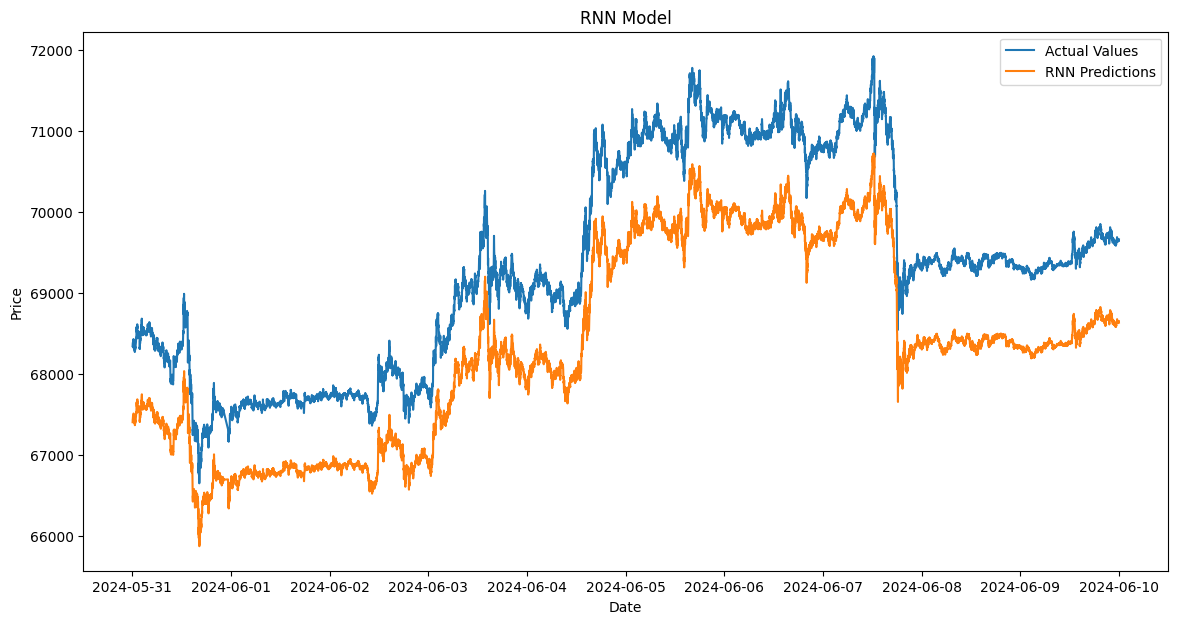

In [28]:
# Create a date range for plotting
plot_dates = future_dates[look_back:]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(plot_dates, future_values[look_back:], label='Actual Values')
plt.plot(plot_dates, rnn_predictions, label='RNN Predictions')
plt.title('RNN Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [29]:
RMSE(future_values[look_back:], rnn_predictions)

Root Mean Squared Error (RMSE): 994.2910741754058


C:\Users\sayed\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


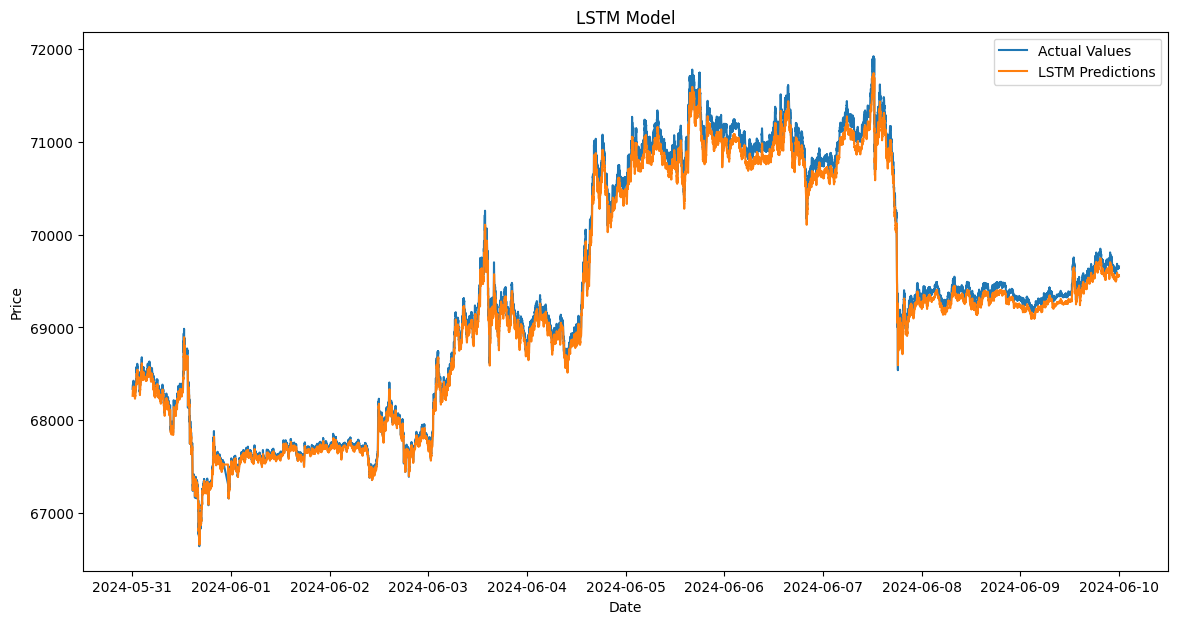

In [30]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(plot_dates, future_values[look_back:], label='Actual Values')
plt.plot(plot_dates, lstm_predictions, label='LSTM Predictions')
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [31]:
RMSE(future_values[look_back:], lstm_predictions)

Root Mean Squared Error (RMSE): 99.5797385957038


C:\Users\sayed\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


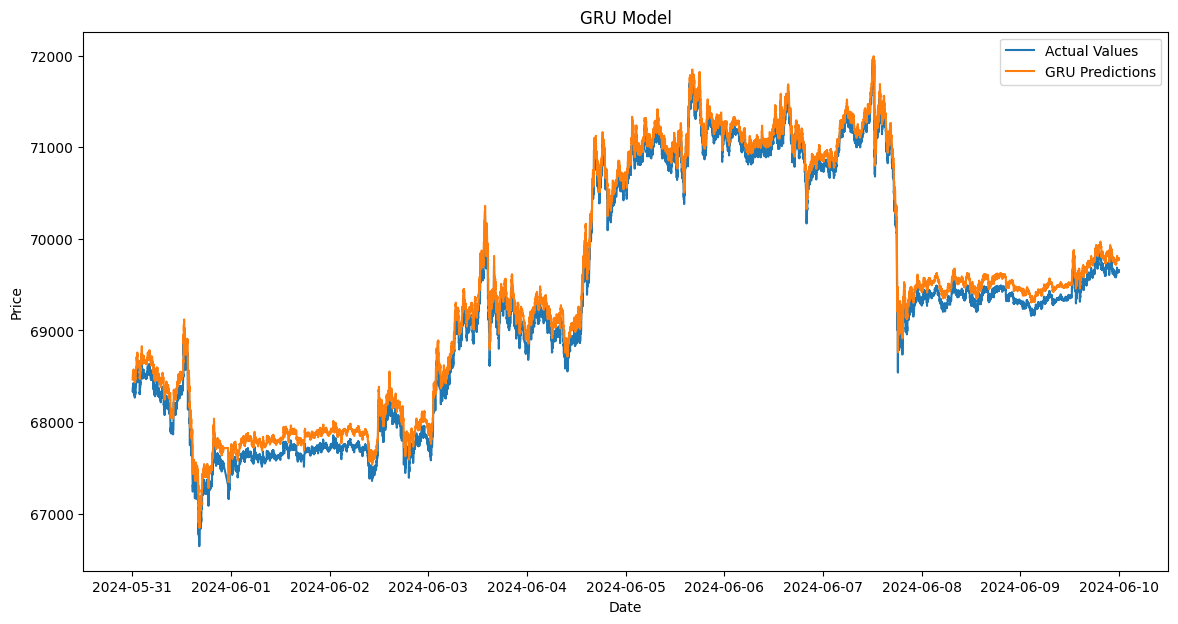

In [32]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(plot_dates, future_values[look_back:], label='Actual Values')
plt.plot(plot_dates, gru_predictions, label='GRU Predictions')
plt.title('GRU Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [33]:
RMSE(future_values[look_back:], gru_predictions)

Root Mean Squared Error (RMSE): 143.2286929807846


C:\Users\sayed\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
